# Trabajo Final: Madrid Central

**Autores:** Fontán, Juan Bosco; Jhangimal, Manoj, Marchán, David; Rivas, Nelson; Valverde, Nicole.


## 1. Introducción

La cantidad de concentración de contaminantes, como el NO2, O3 y PM10 por metros cúbicos, ha empeorado substancialmente en los últimos años, pero la substancia contaminante que sobrepasó los límites establecido por la OMS es el NO2 producido por el tráfico rodado. Por esto, el 30 de noviembre del 2018 se inició un proyecto en **Madrid Central**, perteneciente al [Plan de Calidad de Aire y Cambio Climático][1] con el objetivo principal de garantizar la calidad del aire que respiran los madrileños y fortalecer la ciudad frente a futuros impactos climáticos.

La forma de garantizar esto es estableciendo restricciones de acceso en vehiculo privado, y favoreciendo el acceso en transporte público, bicicleta, peatonal y en vehículos menos contaminantes y de movilidad compartida al area denominada Madrid Central (la cual se mostrará más adelante en un mapa).

En este trabajo, se realizará un análisis exploratorio de la calidad del aire de Madrid (medido a través del NO2) antes y después de la implementación de esta política, sin embargo, el alcance del documento no es el de evaluar la efectividad del programa ni el efecto causal del mismo.


[1]:https://transparencia.madrid.es/UnidadesDescentralizadas/Sostenibilidad/CalidadAire/Ficheros/PlanACalidadAire2019.pdf

## 2. Datos

Los datos a emplear en el presente análisis fueron obtenidos en el [Portal de datos abiertos del Ayuntamiento de Madrid][2], siendo estos:

* [Datos diarios de la Calidad del aire][3]
* [Localización de las estaciones de control de la Calidad del aire][4]
* [Delimitacion del área Madrid Central][5]


[2]:https://datos.madrid.es/portal/site/egob
[3]:https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=aecb88a7e2b73410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default
[4]:https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=9e42c176313eb410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default
[5]:https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=019f24aaef3d3610VgnVCM1000001d4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default

## 2.1 Preparación de los datos

La forma en que se preparará los datos para el análisis es la siguiente:

1. Se importarán las series de observaciones diarias de la calidad del aire en Madrid y se limpiarán hasta obtener lo que llamaremos **data_final**.
2. Se extraerá la información de la estaciones de control de la calidad del aire y su localización y se la tratará hasta generar el dataframe **estaciones**.
3. Finalmente, se cruzarará ambos dataframes para contar con la misma información en una sola base.

**data_final**, **estaciones** y **cruce** contienen los datos a partir de los cuales se generarán las tablas y gráficos que se presentarán en la Sección 3.

### 2.1.1 Datos diarios de la calidad del aire en Madrid

#### 2.1.1.1 Importación:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams['figure.figsize'] = 20,9

In [3]:
consolidado = pd.read_csv('data/consolidado_csv.csv', index_col=False, sep = ';',encoding = 'utf-8-sig')
consolidado.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,D01,V01,D02,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,28,79,4,1,28079004_1_38,2017,1,6.0,V,8.0,...,5.0,V,4.0,V,4.0,V,5.0,V,7.0,V
1,28,79,4,1,28079004_1_38,2017,2,8.0,V,4.0,...,4.0,V,4.0,V,0.0,N,0.0,N,0.0,N
2,28,79,4,1,28079004_1_38,2017,3,5.0,V,7.0,...,4.0,V,5.0,V,7.0,V,7.0,V,5.0,V
3,28,79,4,1,28079004_1_38,2017,4,4.0,V,4.0,...,3.0,V,4.0,V,4.0,V,4.0,V,0.0,N
4,28,79,4,1,28079004_1_38,2017,5,4.0,V,5.0,...,5.0,V,5.0,V,4.0,V,4.0,V,5.0,V


#### 2.1.1.2 Limpieza:

Se limpia el dataframe **consolidado** mediante la agrupación de los valores correspondientes al *día* y la *validez* en dos diferentes dataframes de formato largo, y luego se procede a unirlos, definiendo como índice las 7 primeras columnas:

In [4]:
indice = consolidado.columns[0:7]
consolidado_val = consolidado.drop(columns = consolidado.columns[7::2])   # para eliminar los datos de los dias
consolidado_dia = consolidado.drop(columns = consolidado.columns[8::2])   # para eliminar los datos de validez


In [5]:
# dataframe formato largo DIA
consolidado_dia_long = consolidado_dia.melt(id_vars=indice, var_name='dia', value_name='valor')
consolidado_dia_long['dia'] = consolidado_dia_long.apply(lambda x: int(x.dia.replace('D','')),axis=1)

# dataframe formato largo VALIDEZ
consolidado_val_long = consolidado_val.melt(id_vars=indice, var_name='dia', value_name='validez')
consolidado_val_long['dia'] = consolidado_val_long.apply(lambda x: int(x.dia.replace('V','')),axis=1)

In [6]:
# unión de los dataframes
data = pd.merge(consolidado_dia_long, consolidado_val_long, on=list(indice) + ['dia'])
data.columns = ['provincia', 'municipio', 'estacion', 'magnitud', 'punto_muestreo', 'ano', 'mes', 'dia', 'valor', 'validez']
data.head()

,provincia,municipio,estacion,magnitud,punto_muestreo,ano,mes,dia,valor,validez
0,28,79,4,1,28079004_1_38,2017,1,1,6.0,V
1,28,79,4,1,28079004_1_38,2017,2,1,8.0,V
2,28,79,4,1,28079004_1_38,2017,3,1,5.0,V
3,28,79,4,1,28079004_1_38,2017,4,1,4.0,V
4,28,79,4,1,28079004_1_38,2017,5,1,4.0,V


Debido a que el NO2 es el contaminante que ha sobrepasado los valores establecidos por la Organizacion Mundial de la Salud (OMS), esta será la sustancia en la que se enfocará este análisis. Con este fin, se crea una nueva columna llamada *contaminante*, a partir de una función que identifica los datos correspondientes a NO2 y agrupa los demás contaminantes como "Otro", que serán eliminados a continuación. 

In [7]:
def tipocontaminante(magnitud):
    if magnitud == 8:
        return 'NO2'
    else:
        return 'Otro'
    
data['contaminante']=data.apply(lambda fila: tipocontaminante(fila.magnitud), axis = 1)
data = data[data.contaminante != 'Otro']
data.head()

,provincia,municipio,estacion,magnitud,punto_muestreo,ano,mes,dia,valor,validez,contaminante
36,28,79,4,8,28079004_8_8,2017,1,1,50.0,V,NO2
37,28,79,4,8,28079004_8_8,2017,2,1,93.0,V,NO2
38,28,79,4,8,28079004_8_8,2017,3,1,40.0,V,NO2
39,28,79,4,8,28079004_8_8,2017,4,1,25.0,V,NO2
40,28,79,4,8,28079004_8_8,2017,5,1,25.0,V,NO2


En cuanto a la variable *punto_muestreo*, es necesario extraer los 8 primeros dígitos para así tener el código de cada estación de medición de calidad de aire en Madrid. Esto será muy útil más adelante para cruzar los datos con la localización de cada estación.

In [8]:
lista = data["punto_muestreo"].str.split('_',expand =True)
id_estacion = lista[0]
data['id_estacion'] = data.apply(lambda x: x.punto_muestreo.split('_')[0], axis=1)
data.drop(['punto_muestreo'], axis = 1, inplace = True)
data.head()

,provincia,municipio,estacion,magnitud,ano,mes,dia,valor,validez,contaminante,id_estacion
36,28,79,4,8,2017,1,1,50.0,V,NO2,28079004
37,28,79,4,8,2017,2,1,93.0,V,NO2,28079004
38,28,79,4,8,2017,3,1,40.0,V,NO2,28079004
39,28,79,4,8,2017,4,1,25.0,V,NO2,28079004
40,28,79,4,8,2017,5,1,25.0,V,NO2,28079004


Para validar que los datos pertenezcan únicamente a la provincia y municipio de Madrid, se realiza un conteo de ambas variables, y efectivamente en los dos casos todos los datos pertenecen a la provincia #28: Madrid, y municipio #79: Madrid.

Como consecuencia, se procede a eliminar ambas columnas.

In [9]:
conteo_provincia = data['provincia'].value_counts()
conteo_provincia_df = pd.DataFrame(conteo_provincia).reset_index()
conteo_provincia_df.columns = ['provincia', 'conteo']
conteo_provincia_df

,provincia,conteo
0,28,25296


In [10]:
conteo_municipio = data['municipio'].value_counts()
conteo_municipio_df = pd.DataFrame(conteo_municipio).reset_index()
conteo_municipio_df.columns = ['municipio', 'conteo']
conteo_municipio_df

,municipio,conteo
0,79,25296


In [11]:
data = data.drop(columns = ['provincia', 'municipio'])

Ademas, la documentación del Ayuntamiento de Madrid sugiere utilizar únicamente los datos que lleven el código de validación "V". 

In [12]:
data = data[data.validez != 'N']

A continuación, se crea una columna fecha y, de aquí en adelante, el análisis se centrará en un periodo antes y después de la implementación de la política, para lo cual se tomará como fecha de corte el 30 de noviembre del 2018.

**Periodos:**
* Antes: 30-nov-2017 al 29-nov-2018
* Después: 30-nov-2018 al 30-oct-2019

In [13]:
#nuevo formato de fecha

from datetime import date, datetime

data['fecha'] = [str(ano) + '-' + str(mes) + '-' + str(dia)
                for ano, mes, dia in data[['ano', 'mes', 'dia']].values]

data.fecha = data.fecha.apply(lambda x : datetime.strptime(x,'%Y-%m-%d'))
data.drop(['ano','mes','dia'], axis = 1, inplace = True)

# corte al 30 de noviembre del 2018

corte = datetime.strptime('2018-11-30', '%Y-%m-%d')

def periodo(fecha, corte):
    if fecha >= corte:
        return 'despues'
    else:
        return 'antes'  

data['tiempo']=data.apply(lambda fila: periodo(fila.fecha, corte), axis = 1)

data_final = data.copy()
data_final = data_final[data_final.fecha >= '2017-11-30']     # para eliminar los datos de antes del 30 de noviembre 
                                                              # del 2017 y así tener un año exacto de observaciones 
                                                              # antes de la implementación del programa.
data_final

,estacion,magnitud,valor,validez,contaminante,id_estacion,fecha,tiempo
47,4,8,48.0,V,NO2,28079004,2017-12-01,antes
107,8,8,64.0,V,NO2,28079008,2017-12-01,antes
251,11,8,47.0,V,NO2,28079011,2017-12-01,antes
335,16,8,34.0,V,NO2,28079016,2017-12-01,antes
395,17,8,36.0,V,NO2,28079017,2017-12-01,antes
...,...,...,...,...,...,...,...,...
159550,60,8,18.0,V,NO2,28079060,2019-03-31,despues
159552,60,8,26.0,V,NO2,28079060,2019-05-31,despues
159554,60,8,14.0,V,NO2,28079060,2019-07-31,despues
159555,60,8,25.0,V,NO2,28079060,2019-08-31,despues


### 2.1.2 Estaciones de control de calidad del aire

#### 2.1.2.1 Importación:

In [14]:
estaciones = pd.read_csv('data/stations.csv',encoding = 'utf-8-sig')

#### 2.1.2.2 Limpieza:

In [15]:
# asignación de nombres a las columnas
estaciones.columns = ['id_estacion','nombre','direccion',
                     'lon','lat','altitud']

# eliminación de columnas innecesarias
estaciones.drop(['direccion', 'altitud'], axis = 1, inplace = True)

# asignación de mismo tipo de dato a las variables id_estacion para luego poder hacer un merge de los dataframes
estaciones["id_estacion"]= estaciones["id_estacion"].astype(int)
data_final["id_estacion"]= data_final["id_estacion"].astype(int)

estaciones

,id_estacion,nombre,lon,lat
0,28079004,Pza. de España,-3.712247,40.423853
1,28079008,Escuelas Aguirre,-3.682319,40.421564
2,28079011,Avda. Ramón y Cajal,-3.677356,40.451475
3,28079016,Arturo Soria,-3.639233,40.440047
4,28079017,Villaverde,-3.713322,40.347139
5,28079018,Farolillo,-3.731853,40.394781
6,28079024,Casa de Campo,-3.747347,40.419356
7,28079027,Barajas Pueblo,-3.580031,40.476928
8,28079035,Pza. del Carmen,-3.703172,40.419208
9,28079036,Moratalaz,-3.645306,40.407947


### 2.1.3 Cruce de dataframes

In [16]:
cruce = estaciones.merge(data_final, on='id_estacion')
cruce

,id_estacion,nombre,lon,lat,estacion,magnitud,valor,validez,contaminante,fecha,tiempo
0,28079004,Pza. de España,-3.712247,40.423853,4,8,48.0,V,NO2,2017-12-01,antes
1,28079004,Pza. de España,-3.712247,40.423853,4,8,21.0,V,NO2,2018-01-01,antes
2,28079004,Pza. de España,-3.712247,40.423853,4,8,58.0,V,NO2,2018-02-01,antes
3,28079004,Pza. de España,-3.712247,40.423853,4,8,35.0,V,NO2,2018-03-01,antes
4,28079004,Pza. de España,-3.712247,40.423853,4,8,38.0,V,NO2,2018-04-01,antes
...,...,...,...,...,...,...,...,...,...,...,...
16698,28079060,Tres Olivos,-3.689761,40.500589,60,8,18.0,V,NO2,2019-03-31,despues
16699,28079060,Tres Olivos,-3.689761,40.500589,60,8,26.0,V,NO2,2019-05-31,despues
16700,28079060,Tres Olivos,-3.689761,40.500589,60,8,14.0,V,NO2,2019-07-31,despues
16701,28079060,Tres Olivos,-3.689761,40.500589,60,8,25.0,V,NO2,2019-08-31,despues


## 3. Análisis

### 3.1 Estaciones de control de calidad de aire en Madrid
Para poder realizar un análisis más concreto y efectivo, se han dividido los datos por la fecha de implantación de Madrid Central. Las estaciones que miden la calidad el aire en el municipio madrileño nos darán los datos necesarios para poder sacar conclusiones. La estación que más nos va a interesar para este estudio es la "Estación del Carmen" situada dentro del perímetro de Madrid Central.

In [17]:
tmp = cruce.groupby(['tiempo','nombre','lat','lon']).valor.mean().reset_index()
tmp_antes = tmp[tmp.tiempo == "antes"]
tmp_despues = tmp[tmp.tiempo == "despues"]

In [18]:
# definición de funciones a utilizar en los mapas

import folium 
import numpy as np 

def colores(valor):
     if 1 <= valor < 25:
        return 'forestgreen'
     elif 25 <= valor < 50 :
        return 'gold'
     elif 50 <= valor < 75:
        return 'orangered'
     elif valor > 75:
        return 'red'
    
def opacidad(valor):
     if 1 <= valor < 25:
        return '1'
     elif 25 <= valor < 50 :
        return '0.5'
     elif 50 <= valor < 75:
        return '0'
     elif valor > 75:
        return '0.25'

def relleno(valor):
     if 1 <= valor < 25:
        return 'forestgreen'
     elif 25 <= valor < 50 :
        return 'gold'
     elif 50 <= valor < 75:
        return 'orangered'
     elif valor > 75:
        return 'red'

 
* Este mapa interactivo representa la localización de las estaciones de medición de la calidad del aire de Madrid. 
* Señalado en verde y dentro de un perímetro delimitado por la línea negra (Madrid Central), podemos encontrar la estación situada en Plaza del Carmen. Esto nos sirve de ayuda a la hora de poder localizar de una manera rápida las estaciones de las que se va a hablar a continuación.

In [19]:
map_madrid = folium.Map(location = [40.423853,-3.712247], zoom_start = 12, tiles = "CartoDB Positron")

estaciones.apply(
    lambda row: folium.Marker([row.lat, row.lon], icon=folium.Icon(color='cadetblue', icon='map-marker'), tooltip='Estación: '+row.nombre, radius=6).add_to(map_madrid),
    axis=1)

folium.Choropleth(
    geo_data= 'data/map.geojson').add_to(map_madrid)

folium.Marker(
    [40.419208,-3.703172], icon=folium.Icon(color='green', icon='tree-deciduous'),tooltip='Estación: Pza. del Carmen', 
    radius=12).add_to(map_madrid)

map_madrid

### 3.2 Evolución del Índice de NO2 en Madrid Central


En el siguiente gráfico, se muestra la evolución diaria de los índices de NO2 en la zona de Madrid Central (Estación Plaza del Carmen).

* La <span style="color:red">línea roja</span> divide la gráfica en dos momentos temporales: antes y después de la implementación del proyecto.

* La <span style="color:green">línea verde</span> indica el punto a partir del cual el índice de la calidad del aire pasa de "Muy bueno" a "Bueno" (según las categorias establecidas en el informe del [Ayuntamiento de Madrid][6] (pág 17).

[6]:https://transparencia.madrid.es/UnidadesDescentralizadas/Sostenibilidad/CalidadAire/Publicaciones/Boletines/2019/2019_10_BolCalAire.pdf

C:\Users\manoj\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


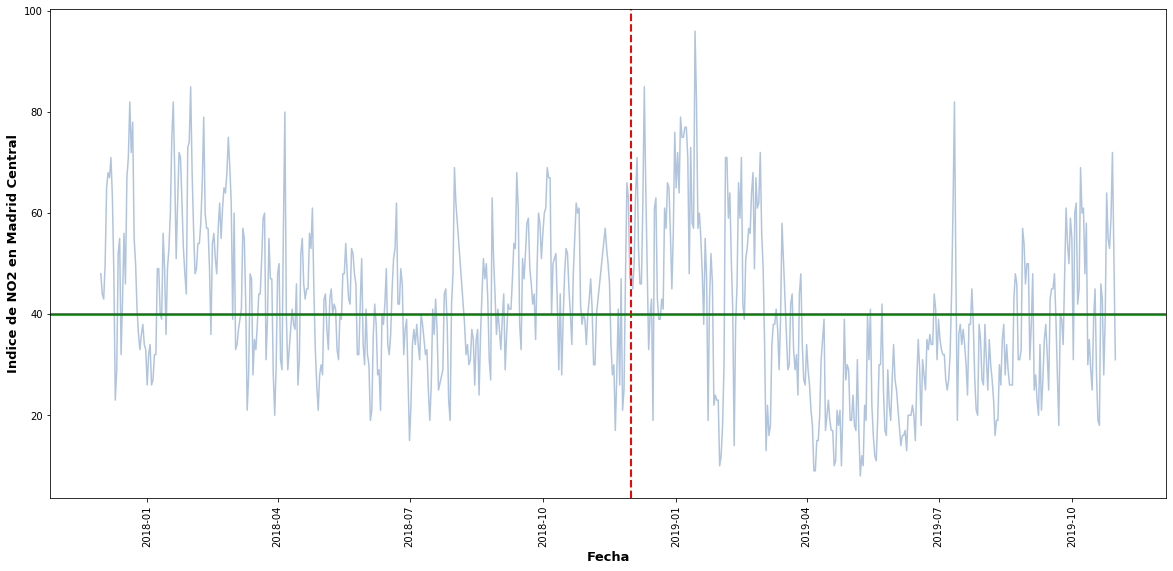

In [20]:
evolucion = sns.lineplot(data=data_final[data_final.id_estacion == 28079035],
                   x='fecha', y='valor',
                   legend=False, color='lightsteelblue')
plt.axvline(x = '2018-12-01', color='red', linestyle='dashed', linewidth=2.0)
plt.axhline(y = 40, color='green', linewidth=2.5)
plt.xlabel('Fecha', fontweight='bold', fontsize=13)
plt.ylabel('Indice de NO2 en Madrid Central', fontweight='bold', fontsize=13)
plt.xticks(rotation=90);

**Análisis:**
* En general, a partir de la <span style="color:red">línea roja</span> que separa los dos momentos temporales, se ve un descenso del nivel del NO2 en la estación que se ubica en Madrid Central, sin embargo, existen momentos concretos que nos pueden dar más información.
* Para poder entender este gráfico mejor, debemos tener en cuenta que el tráfico rodado podía entrar a Madrid Central sin ser multado hasta [Marzo de 2019][7], es decir, cuatro meses más tarde de la implantación de la medida. Es en este momento, el comienzo de la penalización por entrar al perímetro, cuando se puede observar una drástica bajada de la cantidad de NO2 en el aire de esta zona.
* Por otra parte, en la primera semana de Julio y, con el cambio de gobierno, la moratoria de Madrid Central se suspendió. Es en este momento donde podemos ver claramente un bgran apuntamiento hacia arriba que nos indica que, en esa semana la calidad del aire empeoró notablemente.


[7]:https://www.diariomotor.com/consejos/fecha-comienzan-multas-madrid-central/

### 3.3 Días al año en función de la calidad del aire

A partir de lo observado en el anterior gráfico, consideramos apropiado realizar un conteo de los días en que los valores del NO2 se encontraron por debajo o por encima de la <span style="color:green">línea verde</span>, es decir, cuántos días el índice estuvo categorizado como Bueno o Muy Bueno, antes y después de la implementación del programa.

In [21]:
# definición de los límites de las categorías

def limite(valor):
    if valor >= 40:
        return 'bueno'
    else:
        return 'muy bueno'  

data_final['indice']=data_final.apply(lambda x: limite(x.valor), axis = 1)

In [22]:
data_final_conteo = data_final[data_final.id_estacion == 28079035].groupby(["tiempo", "indice"]).size()
data_final_conteo = data_final_conteo.reset_index(name="num_dias")
data_final_conteo = data_final_conteo.pivot_table(index=['indice'], columns='tiempo', values='num_dias').reset_index()
data_final_conteo

tiempo,indice,antes,despues
0,bueno,215,130
1,muy bueno,138,201


En la siguiente gráfica, se muestra el porcentaje de días al año donde la calidad del aire ha sido ["Muy Buena" o "Buena"][8] (tomando como valor la cantidad de NO2) en el periodo de antes de la medida medioambiental y después de la misma.

[8]:https://transparencia.madrid.es/UnidadesDescentralizadas/Sostenibilidad/CalidadAire/Publicaciones/Boletines/2019/2019_10_BolCalAire.pdf

In [23]:
melt = data_final_conteo.melt(id_vars = "indice")
Antes = melt[melt.tiempo == "antes"]
Despues = melt[melt.tiempo == "despues"]
Despues
Antes = Antes.copy() 

# cálculo de porcentajes
Antes['promedio'] = Antes.value/sum(Antes.value)
Despues = Despues.copy() 
Despues['promedio'] = Despues.value/sum(Despues.value)
Despues

data_final_conteo = Antes.append(Despues)

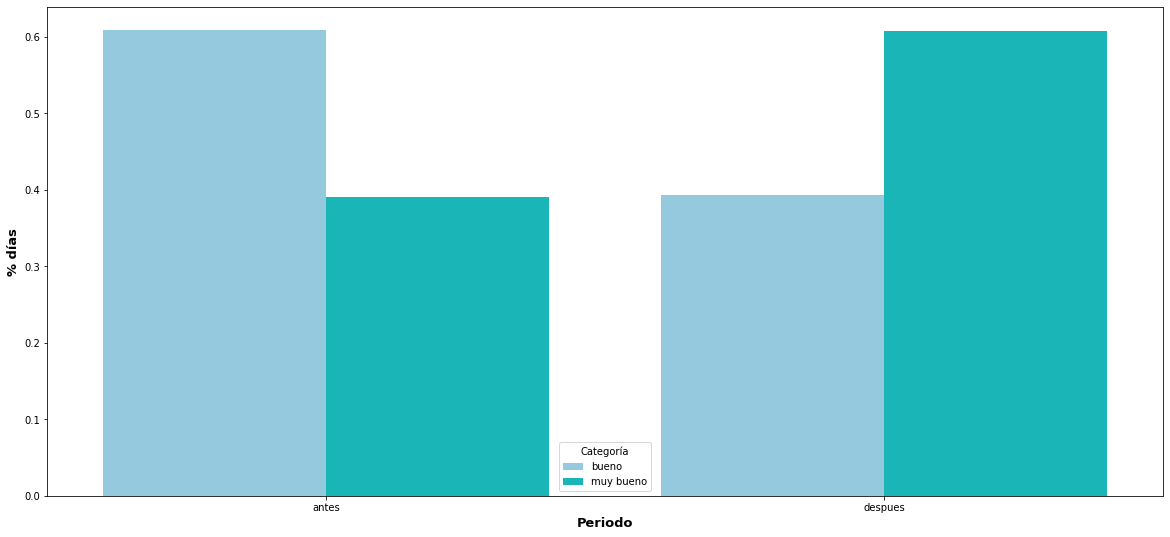

In [24]:
out = sns.barplot(x='tiempo', y='promedio', data=data_final_conteo, hue='indice', 
                  palette=["skyblue", "darkturquoise"])

plt.xlabel('Periodo', fontweight='bold', fontsize=13)
plt.ylabel('% días', fontweight='bold', fontsize=13)
plt.legend(title='Categoría');

**Análisis:**
* En este caso se ve en el gráfico una evidente inversión de los datos. Donde anteriormente el 60% de los días la calidad del aire era "buena", ahora es "muy buena", y viceversa.

### 3.4 Distribución del Índice de NO2 antes y después

Tomando como valor el NO2 (Estación Plaza del Carmen) y midiendo su frecuencia, podemos obtener un gráfico como este. 

**Análisis:**
* La acumulación de datos de NO2 en el periodo de antes de la medida de Madrid Central se encuentra en la parte central del gráfico donde el nivel de N02 es comparativamente más alto, que en el periodo de después de la implantación, que acumula el nivel de NO2 en la parte izquierda del gráfico donde es más bajo y la calidad del aire consecuentemente, mejor.

C:\Users\manoj\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\manoj\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


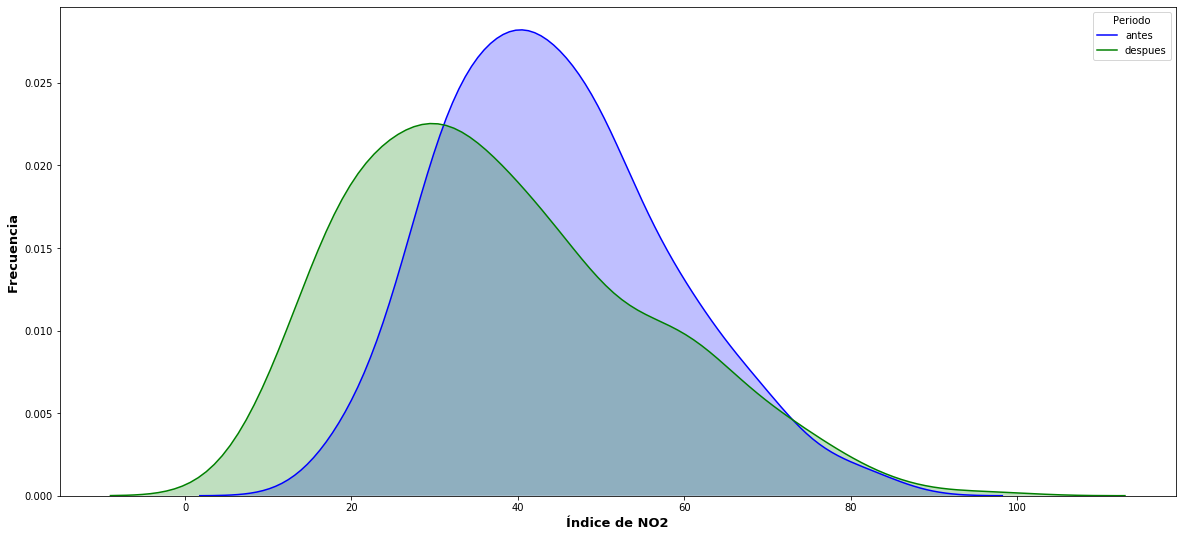

In [25]:
data_final_ancha = data_final[data_final.id_estacion==28079035].pivot_table(index=['estacion', 'magnitud', 'validez',
       'contaminante', 'id_estacion', 'fecha', 'indice'], columns='tiempo', values='valor')

p1=sns.kdeplot(data_final_ancha['antes'], shade=True, color="b")
p1=sns.kdeplot(data_final_ancha['despues'], shade=True, color="g")
plt.xlabel('Índice de NO2', fontweight='bold', fontsize=13)
plt.ylabel('Frecuencia', fontweight='bold', fontsize=13)
plt.legend(title='Periodo');

### 3.5 Estaciones por calidad del aire

En este mapa interactivo están representadas las estaciones de calidad del aire de Madrid después de la medida medioambiental. Pinchando en cada estación se encontrará el valor medio durante Madrid Central.
Los colores de las estaciones se distribuyen por el índice de NO2 medio en este periodo donde:
* <span style="color:forestgreen">Verde</span> es equivalente a menor de 25 µg/m3.
* En <span style="color:gold">amarillo</span> las estaciones entre 25 y 50 µg/m3.
* <span style="color:orangered">Naranja</span> equivale a valores entre 50 y 75 µg/m3.

**Análisis:**
* Se puede observar que las estaciones más alejadas de la vida de ciudad obtienen un mejor dato de calidad del aire, mientras que las estaciones más céntricas como "Escuelas Aguirre" se encuentran en color naranja.


###### µg/m3 = Microgramo por metro cúbico.

In [26]:
map_madrid = folium.Map(location = [40.423853,-3.712247], zoom_start = 12, tiles = "CartoDBPositron")
tmp_despues.apply(
    lambda row: folium.Circle([row.lat, row.lon], tooltip='Estación: '+row.nombre, opacity=opacidad(row.valor), popup=round(row.valor,2),
                fill=True, fill_color=relleno(row.valor), radius=200, color = colores(row.valor)).add_to(map_madrid), axis=1
)
folium.Choropleth(
    geo_data= 'data/map.geojson', 
).add_to(map_madrid)
folium.LayerControl().add_to(map_madrid)
map_madrid 


### 3.6. Variación porcentual NO2

En este gráfico se muestra la variación porcentual del NO2 en las estaciones de control de la calidad del aire de Madrid entre los periodos de antes y después de la implantación de la medida de Madrid Central. 

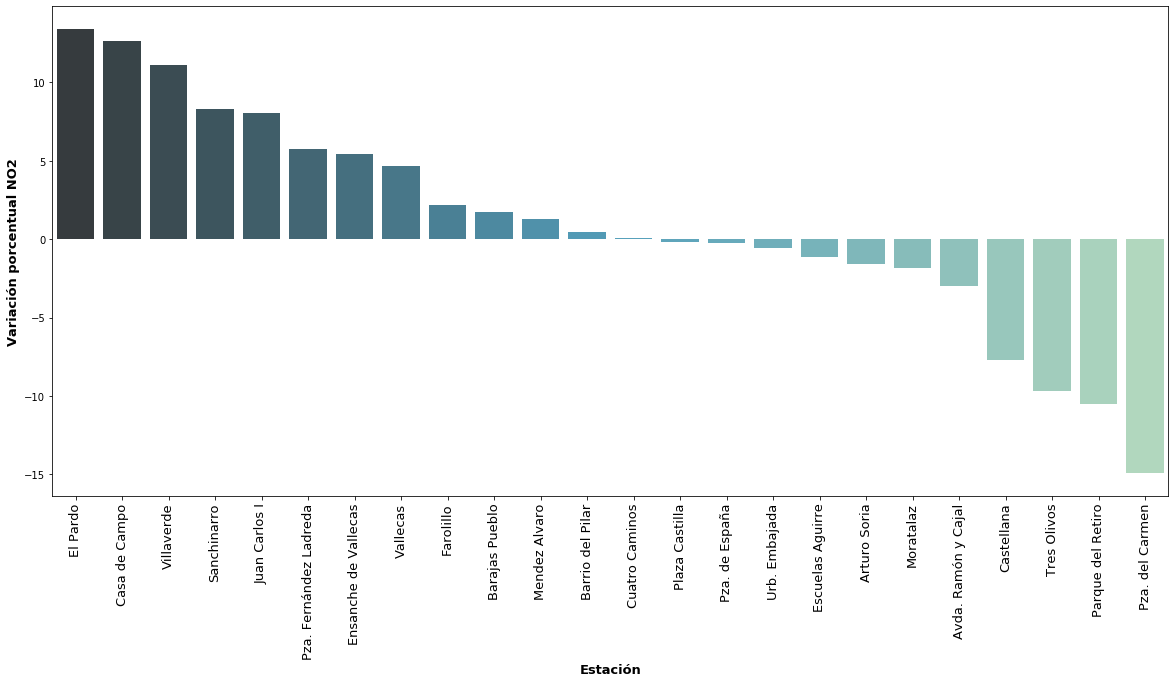

In [27]:
tmp_ancha = tmp.pivot_table(index=['nombre', 'lat', 'lon'], columns='tiempo', values='valor').reset_index()
tmp_ancha['diferencia'] = (tmp_ancha['despues']-tmp_ancha['antes'])/tmp_ancha['antes']*100
tmp_ancha = tmp_ancha.sort_values('diferencia', ascending=False)


out2 = sns.barplot(data=tmp_ancha,
                   x='nombre', y='diferencia', palette = 'GnBu_d')
out2=out2.set_xticklabels(out2.get_xticklabels(), rotation=90, fontsize=13)

plt.xlabel('Estación', fontweight='bold', fontsize=13)
plt.ylabel('Variación porcentual NO2', fontweight='bold', fontsize=13);

**Análisis:**
* De forma general se puede observar que existe un 50% de estaciones donde la calidad del aire ha empeorado y, casi de forma idéntica e invertida, el otro 50% ha mejorado.
* Si nos fijamos en la estación que recoje la calidad del aire de Madrid Central, vemos que **ha disminuido un 15% la cantidad de N02 en promedio**.
* Por otro lado, se puede observar que las estaciones que más empeoran su calidad del aire son las que están situadas a las afueras de Madrid, lo que puede ser un signo de que el tráfico rodado no haya desaparecido sino que se ha desplazado.


## 4. Conclusiones

De manera general, se puede observar una mejora en la calidad del aire posterior a la implementación de la política. 

* La evolución de la variable Índice de NO2 muestra como, en general, después de que comenzaran las multas por ingresar a la zona de cero emisiones, Madrid Central, disminuyó en comparación con el periodo anterior.
* La distribución del mismo índice se ha desplazado favorablemente a la izquierda, significando que los valores que más se repiten ahora son menores a los de antes del programa. 
* Revisando la variación porcentual en las diferentes estaciones de Madrid, se observa como la estación de Plaza del Carmen, ubicada en la zona de Madrid Central, es la que presenta el mayor porcentaje de disminución de NO2.

